In [1]:
import umap
import pandas as pd
import numpy as np
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

C:\Users\yvjennig\.conda\envs\clustering_real\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\yvjennig\.conda\envs\clustering_real\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\yvjennig\.conda\envs\clustering_real\lib\site-packages\umap\d

In [2]:
import dask
from dask.distributed import Client

In [3]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50283,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.67 GiB
Comm: tcp://127.0.0.1:50306,Total threads: 4
Dashboard: http://127.0.0.1:50309/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:50286,


In [5]:
@dask.delayed
def compute_scores(df, compute_scores_on=None, algorithm="kmeans", iterations=10):
    if compute_scores_on is not None:
        X = compute_scores_on.copy()
    else:
        X = df.copy()

    hyp_dict = hyps[algorithm]
    hyp_combinations = list(it.product(*hyp_dict.values()))
    scores = pd.DataFrame(columns=["iteration", "silhouette", "davies_bouldin", "calinski"] + list(hyp_dict.keys()))
    for i in range(iterations):
        print(i)
        for h in hyp_combinations:
            # print(h)
            hyp_dict = dict((b, a) for a, b in zip(h, hyp_dict.keys()))
            if algorithm == "kmeans":
                kmeans = KMeans(**hyp_dict).fit(df)
                y_pred = kmeans.predict(df)
            elif algorithm == "ward":
                model = AgglomerativeClustering(**hyp_dict).fit(df)
                y_pred = model.labels_
            elif algorithm == "dbscan":
                model = DBSCAN(**hyp_dict).fit(df)
                y_pred = model.labels_
            elif algorithm == "optics":
                model = OPTICS(**hyp_dict).fit(df)
                y_pred = model.labels_
            else:
                print("Clustering algorithm not implemented")

            nclusters = len(np.unique(y_pred))
            if nclusters > 1:
                sil = silhouette_score(X, y_pred)
                db = davies_bouldin_score(X, y_pred)
                cal = calinski_harabasz_score(X, y_pred)
            else:
                sil = np.nan
                db = np.nan
                cal = np.nan

            scores = pd.concat([scores, pd.DataFrame({"nclusters": nclusters, "iteration": [i], "silhouette": [sil], 
                                                      "davies_bouldin": [db], "calinski": [cal]})])
            scores.reset_index(inplace=True, drop=True)
            scores = scores.combine_first(pd.DataFrame.from_dict([hyp_dict]).set_index(pd.Series(len(scores)-1)))

    scores["silhouette"] = scores["silhouette"].astype(float)
    scores["davies_bouldin"] = scores["davies_bouldin"].astype(float)
    scores["calinski"] = scores["calinski"].astype(float)
    scores["iteration"] = scores["iteration"].astype(int)
    scores["nclusters"] = scores["nclusters"].astype(int)

    return scores

In [6]:
def plot_score(df, x, y, save_as=None):
    xmap = {"n_clusters": "Number of clusters", "eps": "Epsilon", "min_samples": "Minimum number of samples"}
    df_mean = df.dropna()[[x, y]].groupby(x).mean()
    if y == "silhouette":
        t = "Silhouette Score"
        optimal_x = df_mean.idxmax().values[0]
    elif y == "davies_bouldin":
        t = "Davies Bouldin Score"
        optimal_x = df_mean.idxmin().values[0]
    elif y == "calinski":
        t = "Calinski Harabasz Score"
        optimal_x = df_mean.idxmax().values[0]

    plt.figure()
    sns.lineplot(df, x=x, y=y)
    plt.ylabel(t)
    plt.xlabel(xmap[x])
    plt.axvline(optimal_x, color="orange")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

In [7]:
def plot_all_scores(scores, x="n_clusters", algorithm="kmeans", output_path="output/clustering/", save_as_suffix=None):
    if save_as_suffix: 
        plot_score(scores, x, "silhouette", save_as=f"{'silhouette'}_{algorithm}_{x}{save_as_suffix}.png") 
        plot_score(scores, x, "davies_bouldin", save_as=f"{'davies_bouldin'}_{algorithm}_{x}{save_as_suffix}.png")  
        plot_score(scores, x, "calinski", save_as=f"{'calinski'}_{algorithm}_{x}{save_as_suffix}.png")  
    else:
        plot_score(scores, x, "silhouette", save_as=None) 
        plot_score(scores, x, "davies_bouldin", save_as=None)  
        plot_score(scores, x, "calinski", save_as=None) 

In [8]:
def conduct_exps(df, embedding, algorithm, n_iterations=10):
    # define variables
    vars = []
    if algorithm == "kmeans" or algorithm == "ward":
        vars = {"n_clusters": int}
    elif algorithm == "dbscan":
        vars = {"eps": float, "min_samples": int}
    
    # compute clusters on original data, scores on original data ------------------------------------------------------------------------------ #
    print("compute clusters on original data, scores on original data")
    coeff_scores_oo = compute_scores(df, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations)

    # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onOriginal_scoresOnOriginal.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onOriginal_scoresOnOriginal_{var}")

    # compute clusters on original data, scores on embedded data ------------------------------------------------------------------------------ #
    print("compute clusters on original data, scores on embedded data")
    coeff_scores_oe = compute_scores(df, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations)

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onOriginal_scoresOnEmbedding.csv", index=False)  # save scores 

    # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onOriginal_scoresOnEmbedding_{var}")

    # compute clusters on embedded data, scores on original data ------------------------------------------------------------------------------ #
    print("compute clusters on embedded data, scores on original data")
    coeff_scores_eo = compute_scores(embedding, compute_scores_on=df, algorithm=algorithm, iterations=n_iterations)

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onEmbedding_scoresOnOriginal.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onEmbedding_scoresOnOriginal_{var}")

    # compute clusters on embedded data, scores on embedded data ------------------------------------------------------------------------------ #
    print("compute clusters on embedded data, scores on embedded data")
    coeff_scores_ee = compute_scores(embedding, compute_scores_on=embedding, algorithm=algorithm, iterations=n_iterations)

#     # make sure variables have the correct type
#     for var, var_type in vars.items():
#         coeff_scores[var] = coeff_scores[var].astype(var_type)

#     coeff_scores.to_csv(f"{algorithm}_onEmbedding_scoresOnEmbedding.csv", index=False)  # save scores 

#     # plot scores
#     for var in vars.keys():
#         plot_all_scores(coeff_scores, x=var, algorithm=algorithm, save_as_suffix=f"_onEmbedding_scoresOnEmbedding_{var}")

    return [coeff_scores_oo, coeff_scores_oe, coeff_scores_eo, coeff_scores_ee]

In [9]:
# define hyperparameter combinations to evaluate
hyps = {"kmeans": {"n_clusters": list(range(1, 16)) + [20, 30, 40, 50, 60], "n_init": ["auto"]},
        "ward": {"n_clusters": range(1, 31), "distance_threshold": [None], "linkage": ["ward"]},
        "dbscan": {"eps": np.linspace(0.1, 0.2, 30), "min_samples": range(2, 10)},
        "optics": {"min_samples": range(1, 16), "max_eps": [np.inf]}}

In [10]:
# load data
df_in = pd.read_csv("data/df_wide_knn.csv") 
df = df_in.drop(["LATITUDE", "LONGITUDE", "LEV_M"], axis=1)  # remove geolocation

# scale data
scaler = MinMaxScaler().fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

# compute embedding
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(df_scaled)

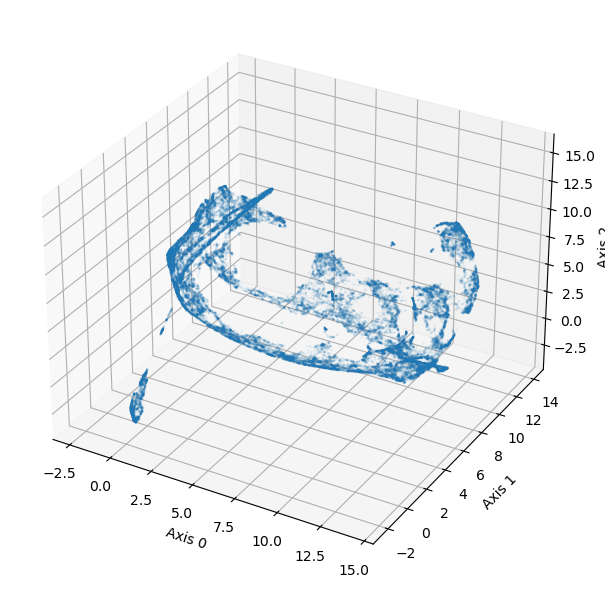

In [11]:
# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
plt.show()

# KMeans

In [43]:
%%time
# compute scores 
scores_kmeans = conduct_exps(df=df_scaled, embedding=embedding, algorithm="kmeans", n_iterations=10)

compute clusters on original data, scores on original data
compute clusters on original data, scores on embedded data
compute clusters on embedded data, scores on original data
compute clusters on embedded data, scores on embedded data
CPU times: total: 0 ns
Wall time: 818 µs


In [44]:
%%time
# 1 iteration = 33min
# 10 iterations = 4h 50min
for i, exp in enumerate(scores_kmeans):
    res = exp.compute()
    res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/kmeans_scores_{i}.csv", index=False)

CPU times: total: 3min 27s
Wall time: 4h 49min 50s


In [ ]:
# plot scores

# Agglomerative Ward clustering

In [12]:
%%time
scores_ward = conduct_exps(df=df_scaled, embedding=embedding, algorithm="ward", n_iterations=10)

compute clusters on original data, scores on original data
compute clusters on original data, scores on embedded data
compute clusters on embedded data, scores on original data
compute clusters on embedded data, scores on embedded data
CPU times: total: 0 ns
Wall time: 1e+03 µs


In [13]:
%%time
for i, exp in enumerate(scores_ward):
    res = exp.compute()
    res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/ward_scores_{i}.csv", index=False)

2023-08-19 09:26:34,660 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:50302 (pid=27288) exceeded 95% memory budget. Restarting...
2023-08-19 09:26:35,198 - distributed.nanny - WARNING - Restarting worker
2023-08-19 09:26:40,345 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:50306 (pid=29968) exceeded 95% memory budget. Restarting...
2023-08-19 09:26:40,796 - distributed.nanny - WARNING - Restarting worker
2023-08-19 09:26:46,143 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:50423 (pid=20372) exceeded 95% memory budget. Restarting...
2023-08-19 09:26:46,485 - distributed.nanny - WARNING - Restarting worker
2023-08-19 09:26:51,560 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:50305 (pid=1208) exceeded 95% memory budget. Restarting...
2023-08-19 09:26:52,170 - distributed.nanny - WARNING - Restarting worker


KilledWorker: Attempted to run task compute_scores-8365e193-0ced-43dd-9a70-9196e60d30e2 on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:50305. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

# DBSCAN

In [ ]:
%%time
scores_dbscan = conduct_exps(df=df_scaled, embedding=embedding, algorithm="dbscan", n_iterations=10)

In [ ]:
%%time
for i, exp in enumerate(scores_dbscan):
    res = exp.compute()
    res.to_csv(f"C:/Users/yvjennig/PycharmProjects/phd_repos/clustering/dbscan_scores_{i}.csv", index=False)